# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [163]:
import os
import io
import requests
import numpy as np
from scipy import stats
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6

## Helpers
# generate straight line
straight_line = lambda y, xs=dates: ([xs[0], xs[-1]], [y, y])
# normalize values by mean and std
norm = lambda x: (np.array(x) - np.nanmean(x)) / np.std(x)

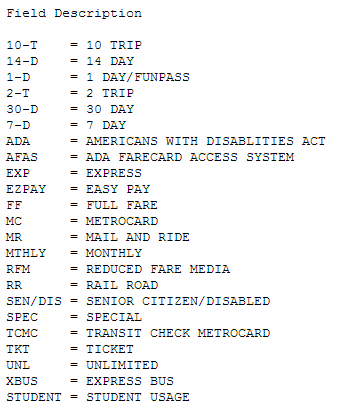

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

In [128]:
card_types = [
    '10 Trip',
    '14 Day',
    '1 Day/Funpass',
    '2 Trip',
    '30 Day',
    '7 Day',
    'Americans with Disability Act',
    'ADA Farecard Access System',
    'Express',
    'Easy Pay',
    'Full Fare',
    'Metrocard',
    'Mail and Ride',
    'Monthly',
    'Reduced Fare Media',
    'Rail Road',
    'Senior Citizen/Disabled',
    'Special',
    'Transit Check Metrocard',
    'Ticket',
    'Unlimited',
    'Express Bus',
    'Student Usage'
]

card_map = {k: i for i, k in enumerate(card_types)}
station_names = ['Station {}'.format(i) for i in range(600)]
len(card_types) # didn't miss any!

23

In [129]:
# get weekly dates starting 5/21/2010 and ending 2/21/2014
start_date = datetime(2010, 5, 21)
end_date = datetime(2014, 2, 21)
sample_period = timedelta(weeks=1)
dates = [
    start_date + i*sample_period 
    for i in range(int((end_date - start_date) / sample_period) + 1)
]

# Not sure why there are 197 weeks... I think your date range is off perhaps
dates = dates[:194]

# Checking date range
dates[:3], '...', dates[-3:], len(dates)

([datetime.datetime(2010, 5, 21, 0, 0),
  datetime.datetime(2010, 5, 28, 0, 0),
  datetime.datetime(2010, 6, 4, 0, 0)],
 '...',
 [datetime.datetime(2014, 1, 17, 0, 0),
  datetime.datetime(2014, 1, 24, 0, 0),
  datetime.datetime(2014, 1, 31, 0, 0)],
 194)

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [168]:
url = 'https://github.com/fedhere/PUI2017_fb55/raw/master/HW10_fb55/MTA_Fare.npy'
fname = os.path.join(os.getenv('PUIDATA'), os.path.basename(url))

# Load data
if os.path.isfile(fname):
    print('from puidata.')
    data = np.load(fname)
else:
    print('from github.')
    data = requests.get(url).content
    with open(fname, 'wb') as f:
        f.write(data)
    data = np.load(io.BytesIO(data))
data.shape

from puidata.


(600, 23, 194)

In [131]:
# Convert -1 to nans
data = data.astype(float)
data[data == -1] = np.nan
data.shape, '{:.2f}% nan'.format(np.isnan(data).sum() / data.size * 100)

((600, 23, 194), '24.26% nan')

In [135]:
# precompute totals for each card, station, and overall
card_data = np.nansum(data, axis=0)
station_data = np.nansum(data, axis=1)
summed_data = np.nanmean(np.nanmean(data, axis=0), axis=0)

station_data.shape, card_data.shape, summed_data.shape

/Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/.direnv/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


((600, 194), (23, 194), (194,))

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.

In [136]:
def event_detection(fares):
    '''Detect event by getting the # standard deviations from the mean'''
    return np.abs(norm(fares))

# Detect largest events
events = event_detection(summed_data)

print('Top 10 Events')
sorted(
    zip(dates, events, range(194)), 
    key=lambda a: a[1]
)[::-1][:10]

Top 10 Events


[(datetime.datetime(2012, 10, 19, 0, 0), 8.7485734610013193, 126),
 (datetime.datetime(2010, 12, 24, 0, 0), 2.666728562730031, 31),
 (datetime.datetime(2010, 12, 17, 0, 0), 2.6643303650395236, 30),
 (datetime.datetime(2012, 12, 14, 0, 0), 2.4587664174315464, 134),
 (datetime.datetime(2011, 8, 19, 0, 0), 2.1990973354471199, 65),
 (datetime.datetime(2012, 3, 16, 0, 0), 2.1339697555204893, 95),
 (datetime.datetime(2011, 9, 16, 0, 0), 2.0688346245911626, 69),
 (datetime.datetime(2011, 12, 16, 0, 0), 2.0121667022867076, 82),
 (datetime.datetime(2013, 12, 13, 0, 0), 1.9124832766169695, 186),
 (datetime.datetime(2013, 12, 6, 0, 0), 1.9092925461582471, 185)]

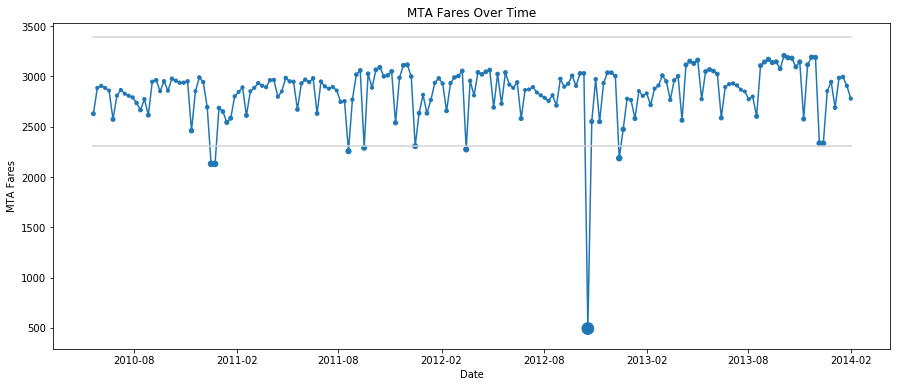

In [137]:
# Plot time series
plt.plot(dates, summed_data)
plt.scatter(dates, summed_data, s=(events+3)**2)
plt.title('MTA Fares Over Time')
plt.xlabel('Date')
plt.ylabel('MTA Fares')

# Plot 1 standard deviation
mu, sigma = np.nanmean(summed_data), np.std(summed_data)
plt.plot(*straight_line(mu - 2*sigma, dates), c='lightgrey')
plt.plot(*straight_line(mu + 2*sigma, dates), c='lightgrey');

### Figure 1: Time series for the sum of all station and card type fares. The size of the point represents the abnormality of the event, as measured by the number of standard deviations from the mean. This shows several smaller events with one large event, a dip down to 500, occuring at 10/19/2012. This is the week of Hurricane Sandy, which most certainly affected MTA traffic. The effect can be seen quite clearly here.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [335]:
def moving_average(fares, window=None, n=10):
    '''Calculate the moving average using an arbitrary window (window normalized to sum to 1)'''
    window = window if window is not None else np.ones((n,))
    pad = (len(window) - 1) / 2
    return np.pad(
        np.convolve(fares, window / window.sum(), mode='valid'),
        np.array([np.ceil(pad), np.floor(pad)]).astype(int),
        mode='edge'
    )

# Create hamming window for moving average
window_size = 12
window = np.hamming(window_size)

# Smooth all card types -> (23, 194)
smoothed = np.apply_along_axis(moving_average, 1, card_data, window=window)

In [391]:
def trend_ratio(fares, n=10):
    '''Calculate the ratio of the fares at the beginning and end of the period
        scaler: I'm using the sigmoid function defined above. The purpose of this is because 
    '''
#     end, start = np.nanmean(fares[-n:]), np.nanmean(fares[:n])
#     return (end - start) / (end + start)
    return np.nanmean(fares[-n:]) / np.nanmean(fares[:n])

def linear_trend_score(fares):
    '''Return the R^2 score of the fares (assumed to be equally spaced)'''
    m, b, r, p, err = stats.linregress(range(len(fares)), fares)
    return r**2

# get start/end ratios for each card type -> (23,)
trend_ratio = np.apply_along_axis(trend_ratio, 1, smoothed)

# get r^2 for each card type -> (23,)
linear_trends = np.apply_along_axis(linear_trend_score, 1, smoothed)

# Merge the r^2 / ratios somehow...
trends = trend_ratio + linear_trends

# Sort the indices by trend ratio -> (23,)
sorted_trends = np.indices(trends.shape).squeeze()[np.argsort(linear_trends)[::-1]]

/Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/.direnv/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


Trends for all Stations (y axis not to scale)


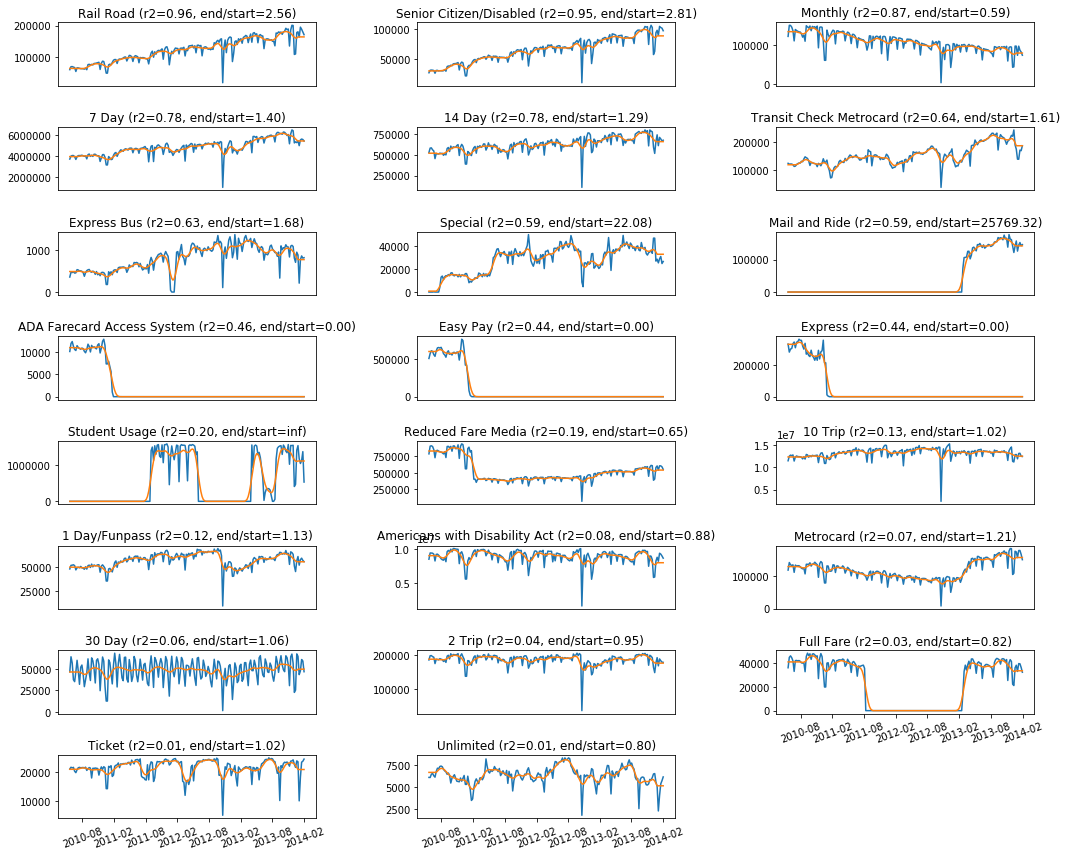

In [392]:
nrows = 3
plt.figure(figsize=(15,12))
for i, tnd in enumerate(sorted_trends, 1):
    plt.subplot(len(smoothed)//nrows+1, nrows, i)
    plt.plot(dates, card_data[tnd])
    plt.plot(dates, smoothed[tnd])
    plt.title('{} (r2={:.2f}, end/start={:.2f})'.format(card_types[tnd], linear_trends[tnd], trend_ratio[tnd]))
    
    if i <= len(smoothed) - nrows:
        plt.gca().get_xaxis().set_visible(False)
    else:
        plt.xticks(rotation=20)
plt.tight_layout()
print('Trends for all Stations (y axis not to scale)')

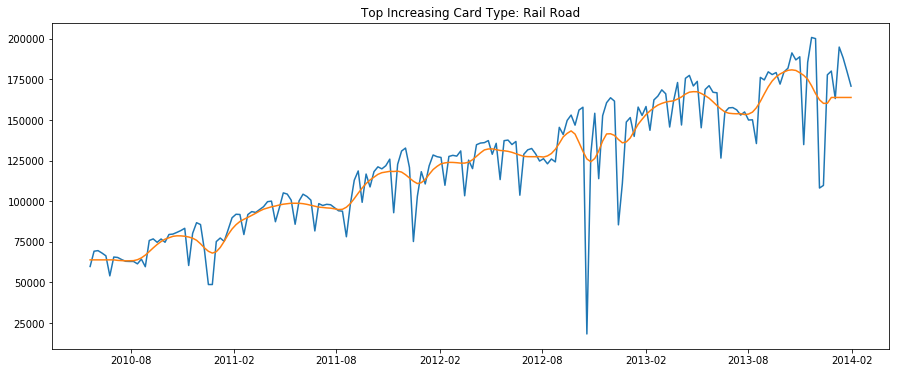

In [345]:
t = sorted_trends[0]
plt.title('Top Increasing Card Type: {}'.format(card_types[t]))
plt.plot(dates, card_data[t,:])
plt.plot(dates, smoothed[t,:]);

### Figure ##: 

## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [143]:
# Compute frequency spacing and the closest frequency to annual
# NOTE: **DC offset was dropped** meaning freq[3] should properly be freq[4]
fs = np.fft.rfftfreq(station_data.shape[-1], d=1./52)[1:]
annual_idx = np.argmin(np.abs(fs - 1))
print('Closest to annual: freq[{}] = {:.3f} cycles per year'.format(annual_idx, fs[annual_idx]))

def calc_periodicity(fares):
    '''Get the power spectrum'''
    return np.abs(np.fft.rfft(fares))**2

# Get power spectrum for all stations -> (600, 194/2+1)
periodicity = np.apply_along_axis(calc_periodicity, 1, station_data)[:,1:]

# select periodicity at 52 weeks for each station -> (600,)
annual_periodicity = periodicity[:,annual_idx]
station_annual = np.argsort(annual_periodicity)[::-1]

print('Most Periodic Stations at Annual Frequency:')
for i, station in enumerate(station_annual[:10], 1):
    print('{}: Station {}'.format(i, station, annual_periodicity[station]))

Closest to annual: freq[3] = 1.072 cycles per year
Most Periodic Stations at Annual Frequency:
1: Station 0
2: Station 194
3: Station 150
4: Station 327
5: Station 32
6: Station 539
7: Station 19
8: Station 169
9: Station 56
10: Station 54


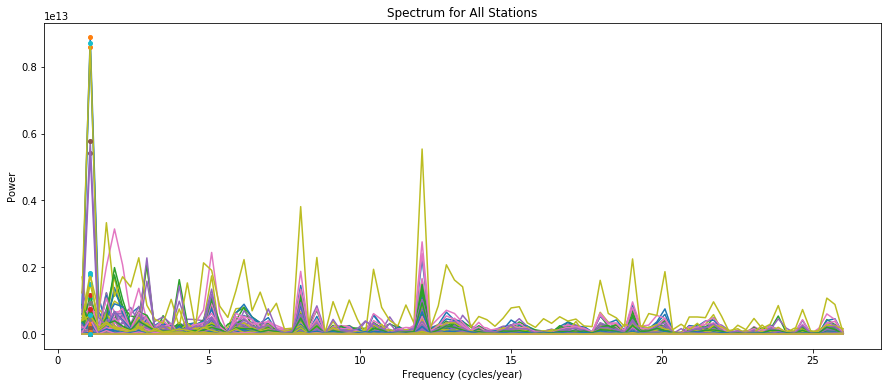

In [160]:
# Plot periodicity of all spectrums
for spec in periodicity:
    plt.plot(fs[2:], spec[2:])
    plt.plot(fs[annual_idx], spec[annual_idx], 'o', ms=4)

plt.title('Spectrum for All Stations')
plt.xlabel('Frequency (cycles/year)')
plt.ylabel('Power');

### Figure ##: The power spectrum for all stations. The points mark the annual frequency. There are 5 stations with large periodicity at the annual level compared to the rest of the spectra. These can be seen clearly by the four points all above y=1e10. 

In [161]:
# Output the most significant peaks
print('Top Peaks by Frequency: ')
for freq, power in sorted(zip(fs, np.max(periodicity, axis=0)), key=lambda a: a[1])[::-1][:5]:
    print('Power at {:.2f} cycles per year ({:.2f} year period): {:.2E}'.format(freq, 1/freq, power))

Top Peaks by Frequency: 
Power at 1.07 cycles per year (0.93 year period): 8.88E+12
Power at 0.27 cycles per year (3.73 year period): 7.20E+12
Power at 12.06 cycles per year (0.08 year period): 5.54E+12
Power at 0.54 cycles per year (1.87 year period): 4.83E+12
Power at 8.04 cycles per year (0.12 year period): 3.81E+12


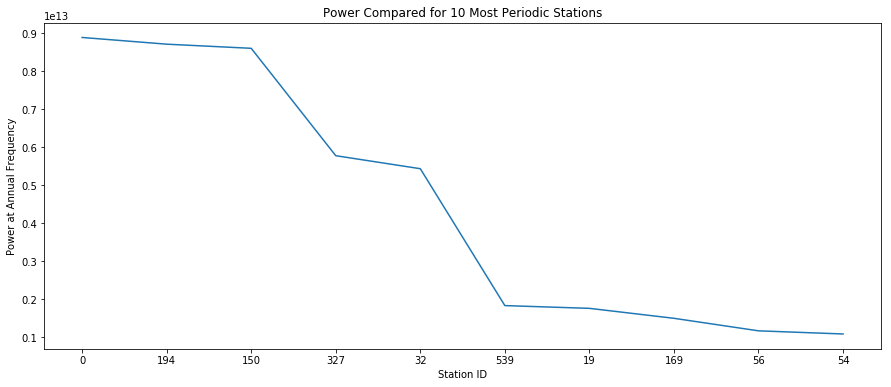

In [155]:
# Plot the power for the top 10 periodic stations
show_n = 10
plt.plot(annual_periodicity[station_annual[:show_n]])
plt.xticks(range(show_n), station_annual[:show_n])
plt.xlabel('Station ID')
plt.ylabel('Power at Annual Frequency')
plt.title('Power Compared for {} Most Periodic Stations'.format(show_n));

### FIgure ##: The power at the annual frequency for the top stations sorted by their power value. This shows a natural grouping of the stations by magnitude. The groups appear to be (by visual inspection), the first 3, the next two, and the rest. This gives a sense of the relative significance of each peak.

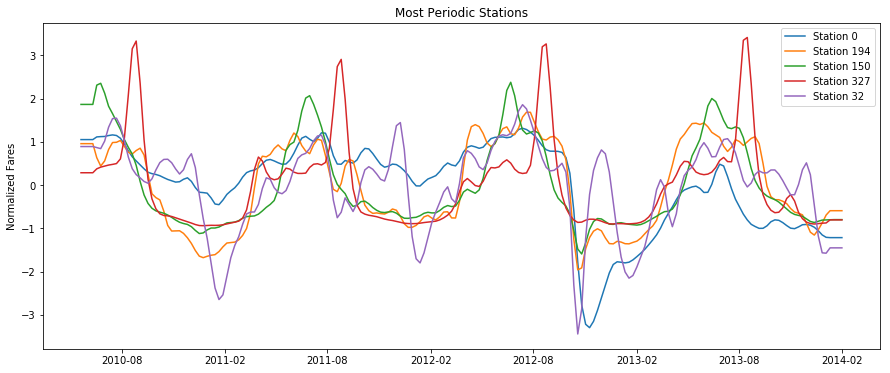

In [397]:
# Get the smoothed spectrum for all stations
smoothed_stations = np.apply_along_axis(moving_average, 1, station_data, window=np.hamming(7))

# Display the top 5 most periodic station
for i in station_annual[:5]:
    station = smoothed_stations[i,:]
    plt.plot(dates, norm(station), label='Station {}'.format(i))

plt.title('Most Periodic Stations')
plt.ylabel('Normalized Fares')
plt.legend();

### FIgure ##: The normalized (and smoothed) time series of the top 5 annually periodic stations. There is a remarkably clear periodicity that can be seen (is it weird to find it exciting?). The lack of any phase differences in the oscillations implies that they share a common cause, perhaps a seasonal trend where people are more inclined to travel to the city during the summer.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

In [361]:
from sklearn.cluster import KMeans

In [401]:
np.apply_along_axis(lambda x: x.shape, 2, np.ones((10,20,30))).shape

(10, 20, 1)

In [414]:
# Using station data
km_data = np.apply_along_axis(norm, 1, station_data)
km_data[~np.isfinite(km_data)] = 0
kmeans = KMeans(n_clusters=10)
classes = kmeans.fit_predict(km_data)

for i in np.unique(classes):
    for s in station_data[classes == i]:
        plt.plot(dates, s)
    plt.title('Cluster {}'.format(i))
    plt.show()

/Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/.direnv/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


(600,)

/Users/bensteers/Desktop/Storage/NYU/Fall2017/PUI/.direnv/python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


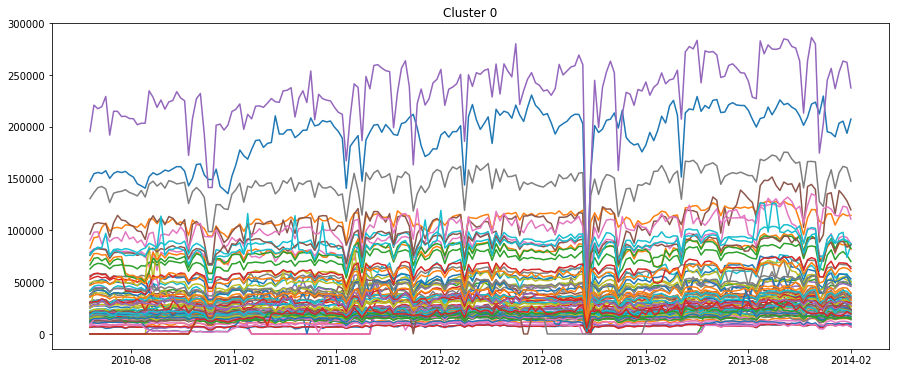

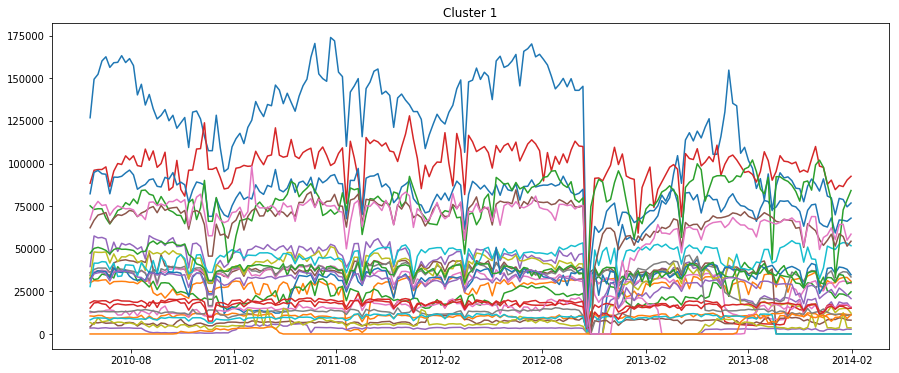

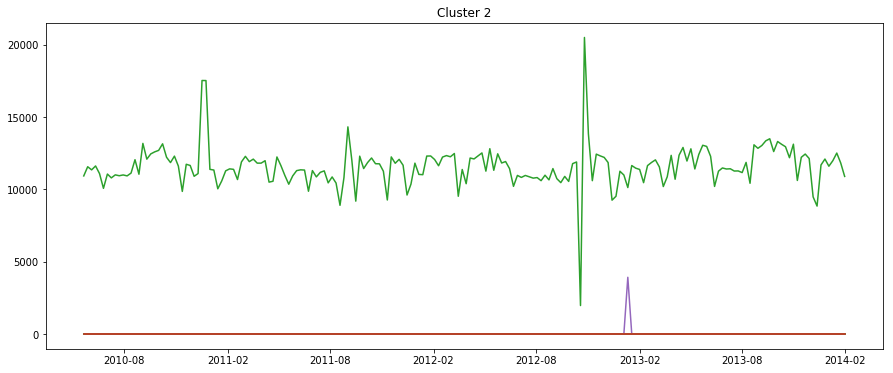

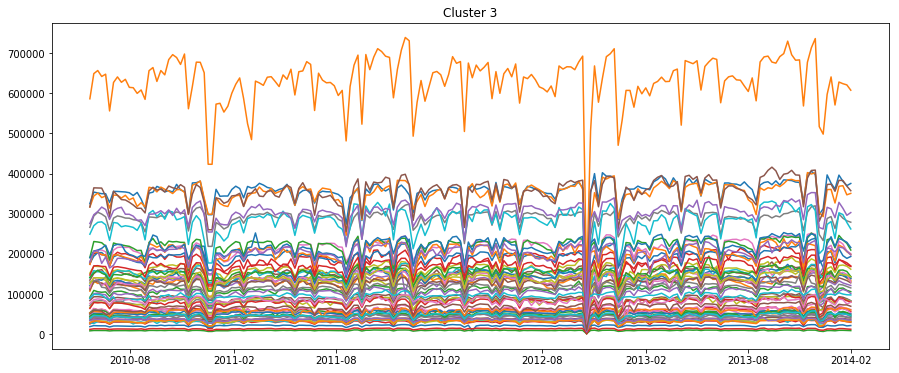

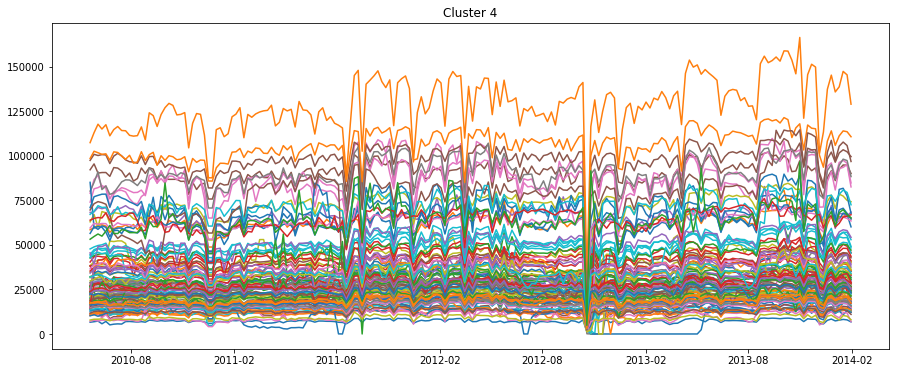

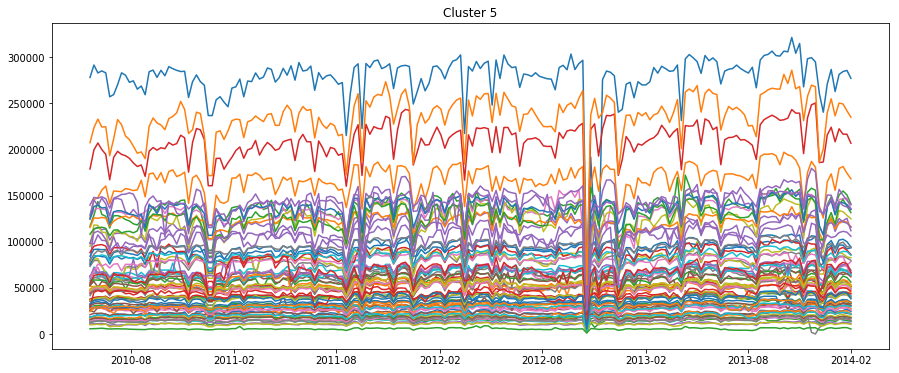

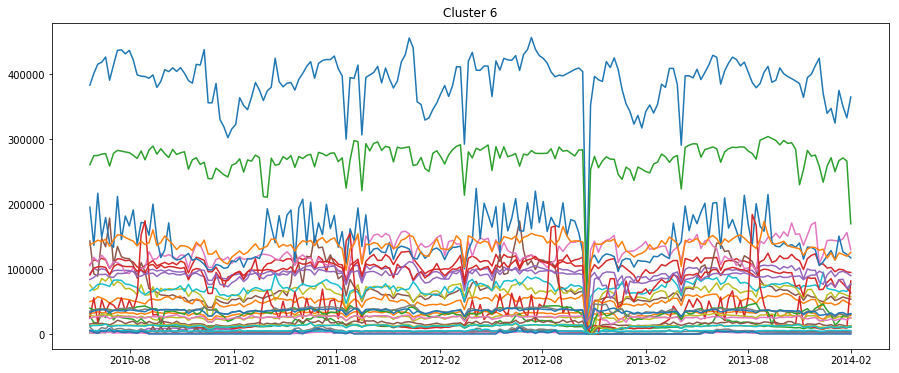

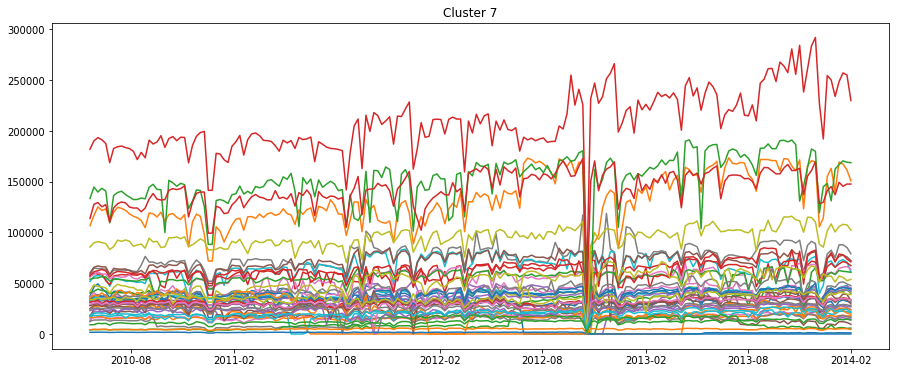

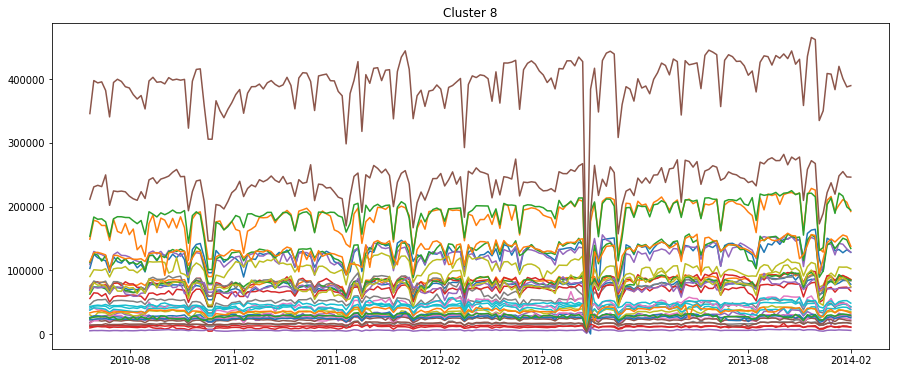

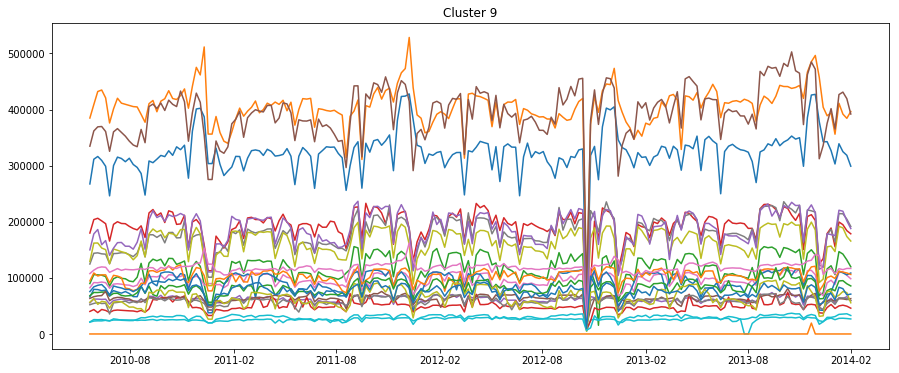

In [419]:
# Using station data
km_data = np.apply_along_axis(norm, 1, periodicity)
km_data[~np.isfinite(km_data)] = 0
kmeans = KMeans(n_clusters=10)
classes = kmeans.fit_predict(km_data)

for i in np.unique(classes):
    for s in station_data[classes == i]:
        plt.plot(dates, s)
    plt.title('Cluster {}'.format(i))
    plt.show()

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

## NOTE ON THE TREND DETECTION:
### you should find the *card type* that has the steepest increase, and the steepest decrease. Notice: we are looking for something that has a more or less constant trend

### to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per ridership type. 

### you can use a rolling mean for smoothing (pd.rolling_mean() for example), and you can calculate the ratio of the *number of rides* near the beginning to the *number of rides* near the end of the time series.

### notice that you should inspect the time series, algorithmically or at least by eye, to ensure you see a trend, and not just changing structure. Below is an example of a lightcurve with structure (top) and a lightcurve with a constant trend (bottom) both showing a large deviation between the beginning and the end of the time series

std: 153167.095823 
flux ratio beginning to end 1.53960256599
std: 33307.6081244 
flux ratio beginning to end 0.378670623705


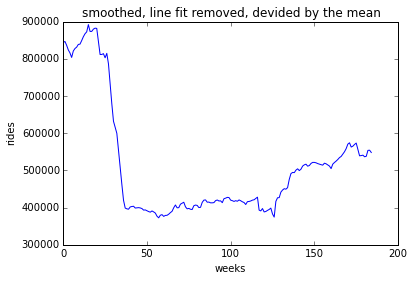

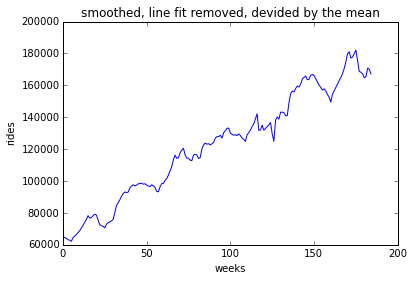

to determine if there is a trend or strucutre you can inspect the time series visually, since there are only 23!
an alternative, algorithmic way to do it, is to fit a line to the (smoothed) time series  and look at the residuals.

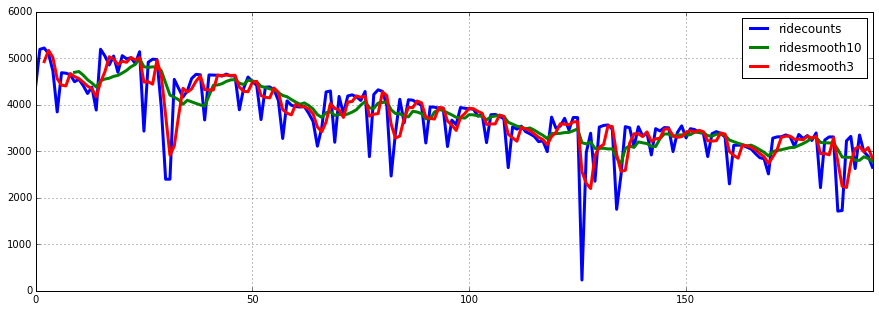

In [14]:
#here is an example of an individual time series that shows a trend, 
#after smoothing by 3 and 10 weeks